In [1]:
%env MKL_THREADING_LAYER=GNU
%env THEANO_FLAGS=device=cuda,floatX=float64
# optimizer=fast_run,NanGuardMode.action=warn
# assert_no_cpu_op='raise'
# use device=cuda for gpu support

env: MKL_THREADING_LAYER=GNU
env: THEANO_FLAGS=device=cuda,floatX=float64


In [2]:
import sys
from __future__ import division
add = __builtin__.sum

In [3]:
from theano import clone, function, pp, shared
from theano.tensor import (concatenate, config, cosh, dot, erfinv, eq, grad, min,
                           scalar, scalars, shape_padright, sum, switch,
                           tensor3, tensor4, tensor5, TensorType, tile, vector)
from theano.tensor.var import TensorVariable
from theano.printing import debugprint, pydotprint
#from theano.tensor.shared_randomstreams import RandomStreams
# used later
from theano.tensor import roll, stack

Using cuDNN version 7005 on context None
Mapped name None to device cuda: GeForce GTX 980 Ti (0000:01:00.0)


In [4]:
from numpy import (array, arange, asarray, exp, full, Inf, linspace,
                   mean, meshgrid, pi, roll)
# used later
#from numpy import roll, stack

In [5]:
from sympy import (Abs, Eq, exp as Exp, I, init_printing, integrate,
                   oo, pi as Pi, solve, symbols, Symbol)
#from sympy.printing.theanocode
# added erfinv
from theanocode import theano_code, theano_function
#from pymatrix import matrix, Matrix

In [6]:
init_printing()

In [7]:
from IPython.display import display, HTML, SVG

In [8]:
%matplotlib inline
from matplotlib.pyplot import (axes, close, contour, contourf, figure,
                               legend, plot, rcParams, scatter, show,
                               title, xlabel, ylabel)
from matplotlib.cm import * #coolwarm, Spectral, etc.
from mpl_toolkits.mplot3d import axes3d
from matplotlib import animation

In [9]:
from sdict import select

In [10]:
from smatrix import *

In [11]:
# function of specified variables fun(y,...) from expression f
# where: fun(x,y)(f)(x,y) = f
def fun(*y):
    if isinstance(y[0],TensorVariable):
        return lambda f: lambda *x: clone(f, dict([[y[i],x[i]] for i in range(len(y))]),strict=False)
    else:
        return lambda f: lambda *x: f.subs( dict([[y[i],x[i]] for i in range(len(y))]))

#### Boundary Conditions

We introduce fictitious worlds, two worlds deep, at the edges of the array to represent boundary conditions. Boundry worlds can be removed or set to zero.

In [12]:
B=2
def boundary0(r):
    for i in range(r.ndim):
        rs = list(r.shape); rs[i]=1
        s = [1]*r.ndim; s[i]=B
        before1 = tile(array([0]*B,config.floatX).reshape(*s),rs)
        s = [1]*r.ndim; s[i]=B
        after1 = tile(array([0]*B,config.floatX).reshape(*s),rs)
        r = concatenate([before1,r,after1], axis=i)
    return r

In [13]:
def boundary(s): return stack([boundary0(r) for r in s])

In [14]:
def debound(r): return r[tuple([slice(B,-B)]*(r.ndim))]

In [15]:
# uniform grid between 0 and 1 of dimension d and size N
def grid(d,N):
    return array(meshgrid(*[arange(0.0+0.5/N,1.0,1.0/N,config.floatX)]*d,
                              indexing='ij'))

### Difference operator ###

Forward and backward differences

In [16]:
def d(dir,x,i):
    if dir<0:
        return roll(x, dir, axis = i) - x
    else:
        return x - roll(x, dir, axis = i)

#### Jacobian ####

In [17]:
def J(C): return matrix([[d(-1,C[j],i) for i in dim] for j in dim])

In [18]:
def K(C): return 1/J(C) # inverse

#### Quantum Potential (Schiff&Poirier eq. 20)####

In [19]:
def Q(hbar,mu,C):
    K_C = K(C)
    return debound(add([add([add([
           -hbar**2/(4*mu[j])*(K_C[k,j]*d(-1,d(+1,K_C[l,j], k), l) + d(+1,K_C[l,j], l)*d(+1,K_C[k,j], k)/2)
                 for k in dim]) for j in dim]) for l in dim]))

The gradient of just the $2^{nd}$ order term in Schiff&Poirier eq. 20 (differing only by the sign), yields the same quantum force as the full expression.
The discretized version of this expression is identical to that introduced by Hall & Deckart.

In [20]:
def Q2(hbar,mu,C):
    K_C = K(C)
    return debound(add([add([add([
           hbar**2/(8*mu[j])*d(+1,K_C[l,j], l)*d(+1,K_C[k,j], k)
                 for k in dim]) for j in dim]) for l in dim]))

#### Quantum Force (Schiff & Poirier eq 18) ####

In [21]:
def R(hbar,mu,C):
    K_C=K(C)
    return stack([debound(add([add([add([add([
      hbar**2/(4*mu[j])*d(+1,K_C[k, i]*K_C[p, j]*d(-1,d(+1,K_C[l, j], k), l), p)
        for p in dim]) for k in dim]) for j in dim]) for l in dim]))
            for i in dim])

### Start with 1-D expressions ##

In [22]:
dim = range(1) # dimension

In the following we use numpy's roll and stack functions for symbolic operations. Later we will use the same theano functions for numeric operations.

In [23]:
from numpy import roll, stack

In [24]:
mu=array(symbols(['mu%s'%i for i in dim])) # mass
hbar=Symbol('hbar')

The multidimensional symbolic array $s$ represents a "uniformizing" mapping of worlds into configuration space, i.e. the position of each particle in each world. Provided the number of worlds is large enough the trace of Q will contain sufficient information to compute the force as a gradient.

In [25]:
N=9 # number of worlds

In [26]:
xb=array(symbols(['%s_{%s}'%('x'.replace(' ',''),str(Symbol("i")+(i-N//2)).replace(' ','')) for i in range(N)]))

The sympy variable names display symbolic indices.

In [27]:
xb.tolist()

The index of the $i^{th}$ world with boundry worlds removed:

In [28]:
x=debound(xb)

In [29]:
ith = N//2-B
x[ith]

The quantum potential at each world:

In [30]:
Qs2=Q2(hbar,mu,[xb])

The $i^{th}$ entry in this array is generic, i.e. independent of the worlds at the boundary. 

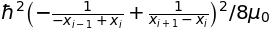

In [31]:
Qs2[ith]

We consider it as a function of its mass $\mu_0$ and 3 variables representing the positions of the particle in the $i^{th}$ world and immediately adjacent worlds .

In [32]:
[x[ith-i] for i in range(-1,2)]

In [33]:
Q1=fun(mu[0],*[x[ith-i] for i in range(-1,2)])(Qs2[ith])

Quantum force at each world:

In [34]:
Rs=R(hbar,mu,[xb])
Rs.shape

Again, the $i^{th}$ entry in these arrays are generic, i.e. independent of the boundary worlds.

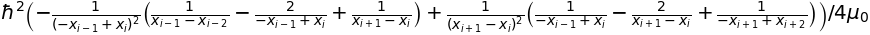

In [35]:
Rs[0,ith]

As expected, the discretized Schiff and Poirier expression for the quantum force is minus the gradient of the trace of the discretized quantum potential.

In [36]:
(Rs[0,ith] - -add([Qs2[i] for i in range(N-2*B)]).diff(x[ith])).simplify()==0

True

We consider it as a function of its mass $\mu_0$ and 5 variables representing the positions of the particle in the $i^{th}$ world and two adjacent worlds to the left and right.

In [37]:
[x[ith-i] for i in range(-2,3)]

In [38]:
R1=fun(mu[0],*[x[ith-i] for i in range(-2,3)])(Rs[0,ith])

The 4-dimensional quantum potential and force can be expressed in terms of the 1-dimensional expressions.

### In 4 dimensions ... ###

The generalization to higher dimensions/multiple particles is essentially trivial.

In [39]:
dim = range(4) # dimension

### Numeric computation ###

These expressions can be converted directly to Theano functions for efficient execution on gpu and multicore processors.

In [40]:
from theano.tensor import roll, stack

In [41]:
hbar_s = scalar('hbar_s')
mu_v = vector('mu_v')
C = TensorType(config.floatX, (False,)*(1+len(dim)))('C') # shape: d * N**d

Replace symbolic differences with vector operators:

In [42]:
from theano.tensor import roll, stack

In [43]:
hbar_s = theano_code(hbar)
mu_v = vector('mu')

Without sympy simplification Theano would produce the following expressions (disabled below since they are not needed in this worksheet):

Even after Theano graph optimization the functions obtained from the sympy simplified expressions above are shorter than those produced directly by Theano. To conversion the sympy expressions to Theano, we just need to replace symbols with appropriate vector operators:

In [44]:
Q2b=fun(hbar_s,mu_v,C)(debound(add([clone(theano_code( # from sympy
                Q1(mu[0],*[x[ith-i] for i in range(-1,2)])),
                dict( # scalar to vector
                      [[theano_code(mu[0]),mu_v[j]]]+
                      # indexed variable to vector operator
                      [[theano_code(x[ith-i]),roll(C[j],i,axis=j)] for i in range(-1,2)]),
                strict=False) for j in dim]) ))
Q2b_=function([hbar_s,mu_v,C],Q2b(hbar_s,mu_v,C))
#SVG(pydotprint(Q2b_.maker.fgraph.outputs[0], return_image=True, format='svg'))

In [45]:
Rb=fun(hbar_s,mu_v,C)(stack([debound(clone(theano_code( # from sympy
                        R1(mu[0],*[x[ith-i] for i in range(-2,3)])),
                        dict( # scalar to vector
                              [[theano_code(mu[0]),mu_v[j]]]+
                              # indexed variable to vector operator
                              [[theano_code(x[ith-i]),roll(C[j],i,axis=j)] for i in range(-2,3)]),
                        strict=False)) for j in dim]))
Rb_=function([hbar_s,mu_v,C],Rb(hbar_s,mu_v,C))
#SVG(pydotprint(Rb_.maker.fgraph.outputs[0], return_image=True, format='svg'))

### Simulation ###

Using the expressions derived above we can generate efficient numerical functions which we use later in determining the motion of a particle in many worlds simultaneously.

We will use the symmetric difference approximation to Poirier's equations above for a numerical simulation of quantum motion in a small number of ``parallel'' worlds.

#### Classical Potential ####

The multidimensional symbolic array $C$ represents a "uniformizing" mapping of worlds into configuration space, i.e. the position of each particle in each world. Provided the number of worlds is large enough the trace of Q will contain sufficient information to compute the force as a gradient.

In [46]:
hbar = scalar('hbar')
mu = vector('mu')

In [47]:
x1,y1,x2,y2=scalars('x1','y1','x2','y2')

In [48]:
# symbolic
V = fun(x1,y1,x2,y2) (10.0*((x1-x2)**2+(y1-y2)**2))

In [49]:
# clone to compile vectorized numeric function
V_ = function([C],V(C[0],C[1],C[2],C[3]))

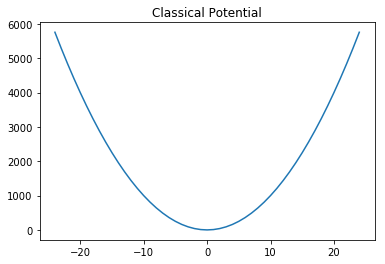

In [50]:
plot(49*(grid(1,49)-0.5)[0],V_(49*(grid(4,49)-0.5))[:,24,24,24])
title('Classical Potential')
show()

#### Classical Force ####

In [51]:
# symbolic gradient
Fx1 = fun(x1,y1,x2,y2) (-grad(V(x1,y1,x2,y2),x1))
Fy1 = fun(x1,y1,x2,y2) (-grad(V(x1,y1,x2,y2),y1))
Fx2 = fun(x1,y1,x2,y2) (-grad(V(x1,y1,x2,y2),x2))
Fy2 = fun(x1,y1,x2,y2) (-grad(V(x1,y1,x2,y2),y2))

In [52]:
F_ = function([C],stack([Fx1(C[0],C[1],C[2],C[3]),Fy1(C[0],C[1],C[2],C[3]),Fx2(C[0],C[1],C[2],C[3]),Fy2(C[0],C[1],C[2],C[3])]))

In [53]:
test=49*(grid(4,49)-0.5)

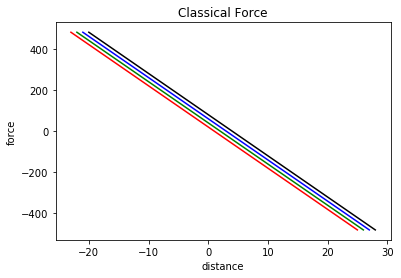

In [54]:
plot(test[0][:,24,24,24]+1, F_(test)[0][:,24,24,24], color='red')
plot(test[1][24,:,24,24]+2, F_(test)[1][24,:,24,24], color='green')
plot(test[2][24,24,:,24]+3, F_(test)[2][24,24,:,24], color='blue')
plot(test[3][24,24,24,:]+4, F_(test)[3][24,24,24,:], color='black')
title('Classical Force')
xlabel('distance'); ylabel('force')
show()

#### Density ####

In [55]:
D_ = function([C],debound(1/J(C).determinant()))

### Initial Data ###

In order to compute the quantum force on the particles in world $n$ we introduce four widely separated fictitious particles in worlds to the left and right to represent open boundary conditions.

For example consider the spatial distribution of a Gaussian ensemble of one particle in  $N$ "parallel" worlds.

In [56]:
N = 20

#### Spatial Distribution

For example consider the spatial distribution of a Gaussian ensemble of one particle in  $N$ ``parallel'' worlds. Everything is in atomic units below, so $\hbar=1$.

In [57]:
bxy=2*(grid(4,N+4)-0.5); bxy.shape

In [58]:
xy=array(map(debound,bxy)); xy.shape

In [59]:
def gauss4(f,xy): return stack([f[0](xy[0]),f[1](xy[1]),f[2](xy[2]),f[3](xy[3])])

In [60]:
b0=gauss4([lambda x0:erfinv(x0)*10,lambda y0:erfinv(y0)*10-10,lambda x1:erfinv(x1)*10-20,lambda y1:erfinv(y1)*10-30],bxy).eval()
b0 *= 10**18; b0[:,1:-1,1:-1,1:-1,1:-1] *= 10**-9; b0[:,2:-2,2:-2,2:-2,2:-2] *= 10**-9
b0.shape

In [61]:
p0 = array(map(debound,b0))
p0.shape

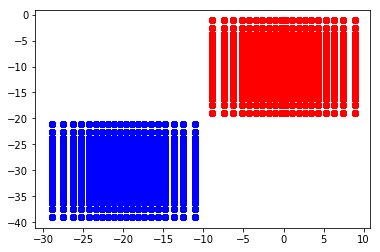

In [62]:
scatter(p0[0],p0[1],color='red')
scatter(p0[2],p0[3],color='blue')
show()

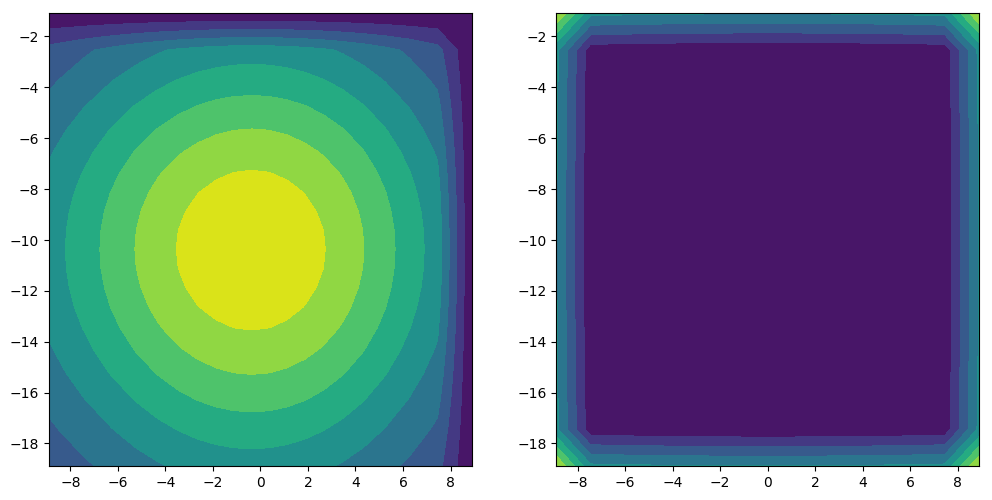

In [63]:
fig = figure(figsize=(12,6),dpi=100)
ax1=fig.add_subplot(121)
#ax1.set_aspect('equal')
ax1.contourf(p0[0][:,:,0,0],p0[1][:,:,0,0],D_(b0)[:,:,0,0],10)
ax2=fig.add_subplot(122)
#ax2.set_aspect('equal')
ax2.contourf(p0[0][:,:,0,0],p0[1][:,:,0,0],Q2b_(1,[1,1,1,1],b0)[:,:,0,0],10)
show()

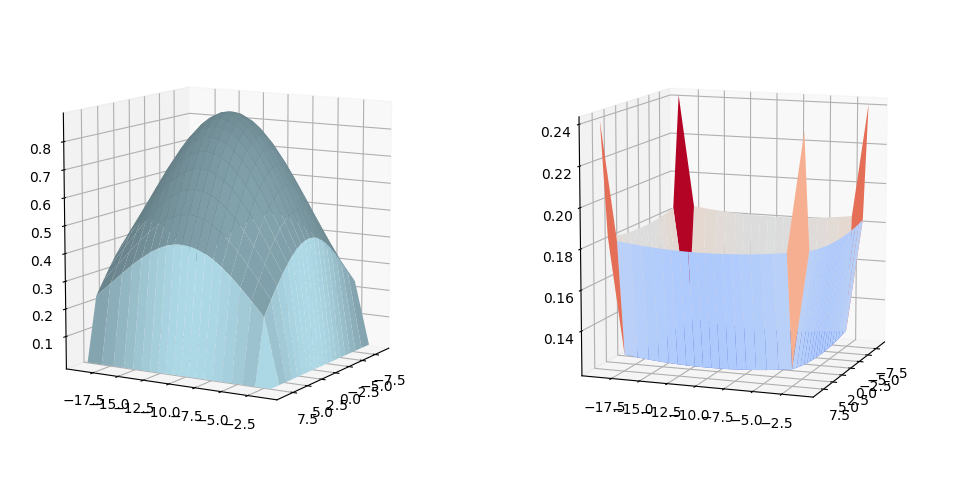

In [64]:
fig = figure(figsize=(12,6),dpi=100)
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
# Plot the surface
ax1.plot_surface(p0[0][:,:,0,0], p0[1][:,:,0,0], D_(b0)[:,:,0,0], color='lightblue', linewidth=0, antialiased=True)
ax1.view_init(10, 30)
ax2.plot_surface(p0[0][:,:,0,0], p0[1][:,:,0,0], Q2b_(1,[1,1,1,1],b0)[:,:,0,0], cmap=coolwarm, linewidth=0, antialiased=True)
ax2.view_init(10, 20)
show()

#### Distribution of Velocity ####
The particles have an identical initial velocity in each world of

In [65]:
v0=full(b0.shape,0.0,config.floatX)
v0=array(meshgrid(
        array([-0.01 for i in range(N+2*B)],config.floatX),
        array([-0.01 for i in range(N+2*B)],config.floatX),
        array([0.01 for i in range(N+2*B)],config.floatX),
        array([0.01 for i in range(N+2*B)],config.floatX)))

#### Acceleration ####

In [66]:
def boundary2(s): return stack([boundary0(s[i]) for i in dim])

In [67]:
def debound2(s): return stack([debound(s[i]) for i in dim])

In [68]:
def F(C): return stack([
            Fx1(C[0],C[1],C[2],C[3]),
            Fy1(C[0],C[1],C[2],C[3]),
            Fx2(C[0],C[1],C[2],C[3]),
            Fy2(C[0],C[1],C[2],C[3])])

In [69]:
def A(hbar,mu,x):
    return shape_padright(1/mu,4)*boundary2(F(debound2(x)) + Rb(hbar,mu,x))

#### Step Size Controller ####
Continuous integrating step size controller \cite{hairer2005}

In [70]:
def G(a,v,alpha):
    eps = 1e-12
    g1 = sum(a*v)
    g2 = sum(v**2)
    return switch(eq(g2,0),1/eps,-alpha*g1/g2)

#### Integration ####
Integrate using the Störmer–Verlet algorithm with adaptive step size.

In [71]:
mu = array([1.0,1.0,1.0,1.0])  # mass
hbar = 1.0 # Planck's constant
rho = shared(asarray(1.0, config.floatX),'rho') # step size control
alpha = scalar('alpha') # sensitivity
ds = scalar('ds')
dt = ds/rho
t = shared(asarray(0.0, config.floatX))
x = shared(b0)

In [72]:
a0 = A(hbar,mu,x).eval()

In [73]:
a = shared(a0)
v = shared(v0)
x_new = x+v*dt+0.5*a*dt**2
a_new = A(hbar,mu,x_new)
v_new = v+0.5*a*dt+0.5*a_new*dt

In [74]:
VerletStep = function([ds,alpha],t, updates=[
    (rho, rho + G(a_new,v_new,alpha)*dt ),
    (x, x_new ),
    (v, v_new ),
    (a, a_new ),
    (t, t + dt)
]) #,allow_input_downcast=True)

#### Energy ####

In [75]:
KU1 = 0.5*sum(mu[0]*v[0]**2+mu[1]*v[1]**2+mu[2]*v[2]**2+mu[3]*v[3]**2)  # total kinetic energy
PU1 = sum(debound(V(x[0],x[1],x[2],x[3])))             # total classical potential
QU1 = sum(Q2b(hbar,mu,x))                         # total quantum potential
E_ = function([],[KU1,PU1,QU1])

In [76]:
E_()

[array(66.3552), array(1436173840.3614573), array(4392.264664293089)]

In [77]:
crossing=function([],min([debound(d(-1,x[0],0)),debound(d(-1,x[1],1)),debound(d(-1,x[2],2)),debound(d(-1,x[3],3))])<0)

In [ ]:
t_start = 0.0; t_end = 20
t_samples = 100; x_samples = N
alpha = 0.0
t_sample = t_end/t_samples
x_sample = __builtin__.max(1,int(N)//int(x_samples))
x_start = __builtin__.max(0,int(N-x_samples*x_sample)//int(2))
XS = array(range(B+x_start,B+N-x_start,x_sample))
ds0 = 1e-5 # 0.0002 # N=10 # initial step size
dsn = 1 # initial step size divider

In [ ]:
while True:
    try: # step size
        ds = ds0/dsn
        # initial values
        rho.set_value(1.0)
        t.set_value(0.0)
        x.set_value(b0)
        v.set_value(v0)
        a.set_value(a0)
        # data recording
        T = [] # sample times
        Rho = [] # steo size
        XX = [] # position
        XV = [] # velocity
        TK = [] # kinetic energy
        TP = [] # classical potential
        TQ = [] # quantum potential
        E = []  # total energy
        try:
            t0 = t.get_value().item()
            while t0<t_end:
                t1 = t0 + t_sample
                [TK1, TP1, TQ1] = E_(); E1 = TK1+TP1+TQ1
                # Check total energy conservation
                if len(E)>1 and abs(E1-E0)>0.1: raise ValueError(
                     "Energy conservation bound failed at %s. Delta E:"\
                    "|%s| > 0.1."%(t0,E1-E0))
                E0 = E1
                if t0>=t_start:
                    T.append(t0) # record samples
                    TK.append(TK1); TP.append(TP1); TQ.append(TQ1); E.append(E1)
                    XX.append(x.get_value()[:,XS][:,:,XS][:,:,:,XS][:,:,:,:,XS])
                    XV.append(v.get_value()[:,XS][:,:,XS][:,:,:,XS][:,:,:,:,XS])
                    Rho.append(rho.get_value().item())
                    print("t = %s t1 = %s rho = %s E1 = %s"%(t0,t1,Rho[-1],E0))
                while t0<t1: # loop
                    t0 = VerletStep(ds,alpha).item()
                    rho0 = rho.get_value().item()
                    if rho0 > 100 or rho0 < 0.01:
                        raise ValueError("Step control failed at %s. rho=%s"%(t0,rho0))
                # Check no-crossing
                #if crossing(): raise ValueError("crossing at %s",t0)
        except KeyboardInterrupt:
            print("Interrupted at %s ..."%(t0))
        break # success!
    except ValueError as msg:
        print(msg)
        #break
        dsn = dsn + 1
        print("Trying a shorter initial step size: %s."%(ds0/dsn))
        continue
tmax = T[-1]
print("t = %d"%tmax)

t = 0.0 t1 = 0.2 rho = 1.0 E1 = 1436178298.98
t = 0.2 t1 = 0.4 rho = 1.0 E1 = 1436178297.68
Energy conservation bound failed at 0.4. Delta E:|0.825862884521| > 0.1.
Trying a shorter initial step size: 5e-06.
t = 0.0 t1 = 0.2 rho = 1.0 E1 = 1436178298.98
t = 0.2 t1 = 0.4 rho = 1.0 E1 = 1436178298.65
Energy conservation bound failed at 0.400004999999. Delta E:|0.20646071434| > 0.1.
Trying a shorter initial step size: 3.33333333333e-06.
t = 0.0 t1 = 0.2 rho = 1.0 E1 = 1436178298.98
t = 0.200003333333 t1 = 0.400003333333 rho = 1.0 E1 = 1436178298.84


Step Density

In [ ]:
figure(figsize=(10,5))
plot(T, Rho)
title('Step Density')
xlabel('time'); ylabel('rho')
show()

#### Quantum Potential, Classical Potential and Kinetic Energy ####

In [ ]:
figure(figsize=(10,5))
plot(T, TK, color='green',label='kinetic')
plot(T, TQ, color='red',label='quantum potential')
plot(T, TP, color='blue',label='classical potential')
legend()
title('Total Energy')
xlabel('time'); ylabel('energy')
show(); close()

In [ ]:
figure(figsize=(10,5))
#plot(T, TK[T],color='green',label='kinetic')
plot(T[40:], TQ[40:],color='red',label='quantum potential')
#plot(T, TP[T],color='blue',label='classical potential')
legend()
title('Total Energy')
xlabel('time'); ylabel('energy')
show(); close()

#### Energy Conservation ####

In [ ]:
figure(figsize=(10,5))
plot(T, E, color='red')
title('Energy Conservation')
xlabel('time'); ylabel('energy')
show()
close()

#### Trajectories ####
The trajectory of the particle in each world is shown below.  Notice how the trajectories do not cross, yet in some worlds the particle is scattered from the barrier while in others the particle tunnels across the barrier "pushed" by its counterpart in other worlds.

In [ ]:
XT=array(XX)

In [ ]:
fig = figure(figsize=(20,10))
ax = fig.gca(projection='3d')
j=0
for i in range(0,N):
    ax.plot(XT[:,0,i+j,i+j,i+j,i+j], XT[:,1,i+j,i+j,i+j,i+j], T, color='red')
    ax.plot(XT[:,2,i+j,i+j,i+j,i+j], XT[:,3,i+j,i+j,i+j,i+j], T, color='blue')
show(); close()

In [ ]:
fig = figure(figsize=(20,10))
ax = fig.gca(projection='3d')

ax.plot(XT[:,0,9,9,9,9], XT[:,1,9,9,9,9], T, color='red')
ax.plot(XT[:,2,9,9,9,9], XT[:,3,9,9,9,9] , T, color='blue')

ax.plot(XT[:,0,10,10,10,10], XT[:,1,10,10,10,10], T, color='red')
ax.plot(XT[:,2,10,10,10,10], XT[:,3,10,10,10,10] , T, color='blue')

ax.plot(XT[:,0,11,11,11,11], XT[:,1,11,11,11,11], T, color='red')
ax.plot(XT[:,2,11,11,11,11], XT[:,3,11,11,11,11] , T, color='blue')

ax.view_init(10, 20)
show(); close()

In [ ]:
figure(figsize=(20,10))
plot(T, mean(XT[:,0],(1,2,3,4)), color='red',label='particle 0: x',linewidth=2)
plot(T, mean(XT[:,1],(1,2,3,4)), color='pink',label='particle 0: y',linewidth=2)
plot(T, mean(XT[:,2],(1,2,3,4)), color='blue',label='particle 1: x',linewidth=2)
plot(T, mean(XT[:,3],(1,2,3,4)), color='lightblue',label='particle 1: y',linewidth=2)
#line_color = Spectral(linspace(0,1,len(XS)))
for i1 in range(8,13): #range(len(XS)):
    for j1 in range(8,13): #range(len(XS)):
        for i2 in range(8,13): #range(len(XS)):
            for j2 in range(8,13): #range(len(XS)):
                plot(T, XT[:,0,i1,j1,i2,j2],color='red',alpha=0.5,linewidth=0.5)
                plot(T, XT[:,1,i1,j1,i2,j2],color='pink',alpha=0.5,linewidth=0.5)
                plot(T, XT[:,2,i1,j1,i2,j2],color='blue',alpha=0.5,linewidth=0.5)
                plot(T, XT[:,3,i1,j1,i2,j2],color='lightblue',alpha=0.5,linewidth=0.5)
legend()
title('World-Particle Trajectories')
xlabel('time'); ylabel('location')
show()

#### Final Distribution ####
The distribution at the end of the simulation shows the reflected and transmitted "wave packets" separating from each other.

In greater detail ...

In [ ]:
scatter(p0[0],p0[1],s=0.1,color='red')
scatter(p0[2],p0[3],s=0.1,color='blue')
show()

In [ ]:
scatter(debound(x[0]).eval(),debound(x[1]).eval(),s=0.05,color='red')
scatter(debound(x[2]).eval(),debound(x[3]).eval(),s=0.05,color='blue')
show()

Tomographic projections

In [ ]:
fig = figure(figsize=(12,6),dpi=100)
ax1=fig.add_subplot(121)
#ax1.set_aspect('equal')
ax1.contourf(mean(debound(x[0]).eval(),(2,3)),mean(debound(x[1]).eval(),(2,3)),mean(D_(x.eval()),(2,3)),30)
ax2=fig.add_subplot(122)
#ax2.set_aspect('equal')
ax2.contourf(mean(debound(x[0]).eval(),(0,1)),mean(debound(x[1]).eval(),(0,1)),mean(D_(x.eval()),(0,1)),30)
xlabel('x'); ylabel('y')
show()

In [ ]:
fig = figure(figsize=(12,6),dpi=100)
ax1=fig.add_subplot(121, projection='3d')
#ax1.set_aspect('equal')
ax1.plot_surface(mean(debound(x[0]).eval(),(2,3)),mean(debound(x[1]).eval(),(2,3)),mean(D_(x.eval()),(2,3)),
                 color='lightblue', linewidth=0, antialiased=True)
ax2=fig.add_subplot(122, projection='3d')
#ax2.set_aspect('equal')
ax2.plot_surface(mean(debound(x[0]).eval(),(0,1)),mean(debound(x[1]).eval(),(0,1)),mean(D_(x.eval()),(0,1)),
                 color='lightblue', linewidth=0, antialiased=True)
xlabel('x'); ylabel('y')
show()